# 多重解像度画像生成メソッド
### **mulresimg(img,minsize=６４)**
#### 入力
>  **img**  入力画像（numpy配列）  

#### パラメータ
>**minsize**  最も小さい画像サイズ

#### 返り値
>サイズを1/2, 1/4, 1/8 ... として作成した画像のリスト　　

#### 注意
>cv.pyrDown による縮小である。この縮小は 1/2 に限定したリサイズであるので、
 画像の縦横の長さは２のべきであることが望ましい。
 
>getbase2img(img,pad）によって２のべきのサイズでもっとも近くなるように余白をつけて処理される。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math

In [2]:
# 最寄りの２のべき乗サイズになるよう padding
def getbase2img(img):
    h = img.shape[0]
    w = img.shape[1]
    lh = math.ceil(math.log(h,2))
    lw = math.ceil(math.log(w,2))
    newh = 2** lh
    neww = 2** lw
    print(h,w,"->",newh,neww)
    if len(img.shape)==3:
        newimg = np.zeros((newh,neww,3),dtype=np.uint8)
    else: # gray
        newimg = np.zeros((newh,neww),np.uint8)    
    newimg[:h,:w] = img.copy()
    return newimg

# Grubcut をマージン5%だけを背景指定して得られる画像を返す
def grubcut(img, offset=5):
    h,w = img.shape[0],img.shape[1]
    offsetY,offsetX = int(h*offset/100),int(w*offset/100)
    bgdmodel = np.zeros((1,65),np.float64)
    fgdmodel = np.zeros((1,65),np.float64)
    mask = np.zeros(img.shape[:2],np.uint8)
    rect=(offsetX,offsetY,img.shape[1]-2*offsetX,img.shape[0]-2*offsetY)
    # print(rect,img.shape,mask.shape)
    cv2.grabCut(img,mask,rect,bgdmodel,fgdmodel,1,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    return img

# grubcut されていることが前提で、背景は完全黒である画像の完全黒部分を余白としてカットする
def margincut(img,pad=5):
    h,w = img.shape[0],img.shape[1]
    padY,padX = int(h*pad/100),int(w*pad/100)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    _img,contours, _hcy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x1,x2,y1,y2 = [],[],[],[]
    for i in range( len(contours)):
        # ret = (x, y, w, h)
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])
    x_min = min(x1)
    y_min = min(y1)
    x_max = max(x2)
    y_max = max(y2)
    
    # pad 分だけ余白をつけてコピー
    x_min -= padX if x_min > padX else x_min
    y_min -= padY if y_min > padY else y_min
    x_max += padX if padX < img.shape[1]-x_max else img.shape[1]-x_max
    y_max += padY if padY < img.shape[0]-y_max else img.shape[0]-y_max
    newimg = img[y_min:y_max,x_min:x_max].copy()
    return newimg,  (x_min,y_min,x_max,y_max)

ShrinkTarget = 64
# 多重解像度画像の生成
def mulresimg(img,minsize=ShrinkTarget,pad=-1,offset=5):
    if pad > 0:  # マージンカットする場合
        w = img.shape[1]
        h = img.shape[0]
        size = np.array([w,h]).min()
        # grubcut は面積に対して線型以上の計算量かかる。512x512で数秒かかるのでそれ以上のサイズで実行するのは
        # 現実的ではない。マージンカットが目的であれば２５６程度の結果を使って差し支えない。
        if size > 256:   
            w1 = w*256//size
            h1 = h*256//size
            refimg = cv2.resize(img,(w1,h1))
            timg = grubcut(refimg,offset=offset)
            timg,(x1,y1,x2,y2)= margincut(timg,pad=pad)
            x1,y1,x2,y2 = int(x1*w/w1),int(y1*h/h1), int(x2*w/w1),int(y2*h/h1)
            img = img[y1:y2+1,x1:x2+1]
        else:
            img = grubcut(img, offset=offset)
    img = getbase2img(img)  # まず 2 のべき乗サイズにする
    mulimg = [img]
    while np.max(img.shape[:2]) > minsize: # 縦横どちらかもが minsize 以下になるまで縮小
        img = cv2.pyrDown(img)
        mulimg.append(img)
    return  mulimg

# 　多重解像度画像を一枚にまとめて表示
def showMimg(mimg):
    w = (mimg[0].shape[1])*3//2
    h = mimg[0].shape[0]
    if len(mimg[0].shape)==3:
        all = np.zeros((h,w,mimg[0].shape[2]),np.uint8)
        c = 3
    else: # gray
        all = np.zeros((h,w),np.uint8)
        c = 1
    y,x = 0,0
    for  index,img in enumerate(mimg):
        w = img.shape[1]
        h = img.shape[0]
        all[y:y+h,x:x+w]=img
        if index%2 == 0:
            x += w
        else:
            y += h
    if c == 1:
        plt.imshow(all,cmap='gray')
    else:
        plt.imshow(all[:,:,::-1])
    plt.show()
    return(all)

#  大きな画像をキー操作で拡大縮小して観察するためのメソッド

**w** または **↑** 　上スクロール  
**z** または **↓**　下スクロール  
**a** または **→**　左スクロール  
**d** または **←**　右スクロール  
**+** 1.4 倍拡大  
**-** 1.4 分の１縮小

In [46]:
#  大きな画像をキー操作で拡大縮小して観察するためのメソッド
def showBigImage(img):
    cv2.namedWindow("AA",cv2.WINDOW_AUTOSIZE)
    ratio = 1.0
    posx,posy = 0,0
    h0 = img.shape[0]
    w0 = img.shape[1]
    WSIZE = 512
    padding = np.zeros((WSIZE,WSIZE,3),np.uint8)
    window = padding.copy()
    endy = posy+WSIZE if posy+WSIZE < h0 else h0
    endx = posx+WSIZE if posx+WSIZE < w0 else w0

    window[:h0,:w0]=img[posy:endy,posx:endx]
    
    cv2.imshow("AA",window)
    
    tmpimg = img.copy()
    
    while(1):
        
        h = tmpimg.shape[0]
        w = tmpimg.shape[1]
        endy = posy+WSIZE if posy+WSIZE < h else h
        endx = posx+WSIZE if posx+WSIZE < w else w
        window = padding.copy()
        window[:endy-posy,:endx-posx]=tmpimg[posy:endy,posx:endx]
        cv2.namedWindow("AA",cv2.WINDOW_AUTOSIZE)
        cv2.imshow("AA",window)

        k = cv2.waitKey(1) # 1milisecond 入力を受け付ける　　0にすると無限に待ってしまう
        
        #if k > 0 :
        #    print(k)
        
        if k == 27:         # 終了は ESC
            break
            
        elif k == ord('w') or k == 63232: # ↑ 
            if posy > 0 :
                posy -= 10
            if posy < 0:
                posy = 0
        elif k == ord('z') or k == 63233: # ↓ 
            if posy < h :
                posy += 10
            if posy > h:
                posy = h
        elif k == ord('a') or k == 63234: # ← 
            if posx > 0 :
                posx -= 10
            if posx < 0:
                posx = 0
        elif k == ord('d') or k == 63235: # →
            if posx < w :
                posx += 10
            if posx > w:
                posy = w
           
        elif k == ord('+'):
            ratio *= 1.414
            newh = int(h0*ratio)
            neww = int(w0*ratio)
            posy = posy+70 if posy+70 < newh-512 else newh-512
            posx = posx+70 if posx+70 < neww-512 else neww-512
            tmpimg = cv2.resize(img,(neww,newh))
        elif k == ord('-'):
            ratio /= 1.414
            newh = int(h0*ratio)
            neww = int(w0*ratio)
            posy = posy-70 if posy > 70 else 0
            posx = posx-70 if posx > 70 else 0
            tmpimg = cv2.resize(img,(neww,newh))
    cv2.destroyAllWindows()        
    cv2.waitKey(1)

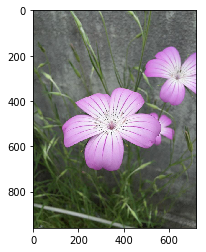

In [4]:
filename = "pics/IMG_5357.jpg" 
src = cv2.imread(filename,1) # 画像の読み込み
plt.imshow(src[:,:,::-1])
plt.show()

多重解像度画像は1/1, 1/2,1/4,1/8... のサイズの画像をパッケージ化したものである。
このため、縦横のサイズは２のべき乗であることが望ましい。

**getbase2img** は元の画像にマージンを追加することで２のべき乗サイズの画像をつくるメソッドである。

余白の付き方

960 720 -> 1024 1024


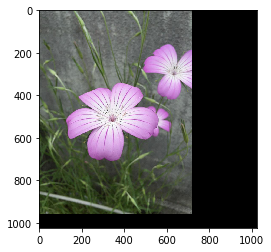

In [5]:
b2img = getbase2img(src)
plt.imshow(b2img[:,:,::-1])
plt.show()

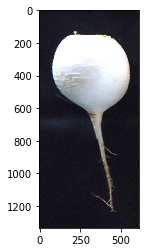

1334 609 -> 2048 1024


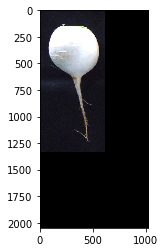

In [6]:
daikonname = "pics/daikonkabu.jpg" 
src = cv2.imread(daikonname,1)
plt.imshow(src[:,:,::-1])
plt.show()
b2img = getbase2img(src)
plt.imshow(b2img[:,:,::-1])
plt.show()

# 多重解像度画像の表示例

**mulresimg** は第１引数で与えた画像を getbase2img で２のべきサイズに変換した後多重解像度画像（画像のリスト）を返す
**showMimg** にそのリストを渡すと１枚の画像に合成して表示するとともにその画像を返す。

960 720 -> 1024 1024


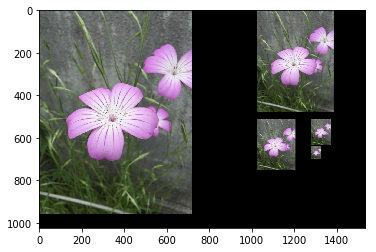

In [7]:
filename = "pics/IMG_5357.jpg" 
src = cv2.imread(filename,1) # 画像の読み込み
mm = mulresimg(src)
showMimg(mm);

1334 609 -> 2048 1024


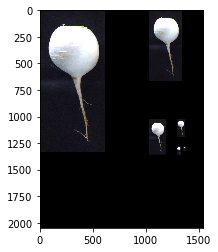

(2048, 1024, 3)

In [8]:
daikonname = "pics/daikonkabu.jpg" 
src = cv2.imread(daikonname,1)
mm = mulresimg(src)
showMimg(mm)
b2img.shape

この画像はサイズが５１２に近いが５１２を超えているので最寄りのべき乗サイズが１０２４となり無駄な余白が多い。
手動でサイズ調整しても良いが、Grubcut による自動余白カットメソッドを用意した。
# grubcut(img,offset=5(%))

**offet** 枠と外縁の間の距離

# margincut(img,pad=5(%))

**pad** で指定した分だけの余白は残す。
** 返り値** img, (xmin, ymin, xmax,ymax)


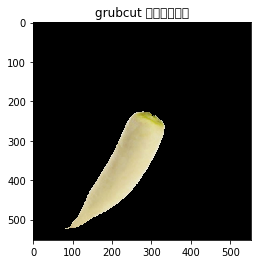

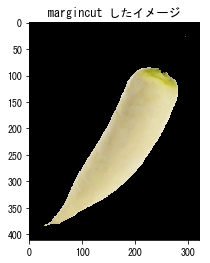

In [9]:
daikonname = "kabukabu.png" 
src = cv2.imread(daikonname,1)
gcimg = grubcut(src, offset=5)
plt.imshow(gcimg[:,:,::-1])
plt.rcParams['font.family'] = 'MS Gothic'
plt.title("grubcut したイメージ")
plt.show()

mcimg,_ = margincut(gcimg,pad=5)
plt.imshow(mcimg[:,:,::-1])
plt.title("margincut したイメージ")
plt.show()

デフォルトで多重解像度画像を作った場合

552 552 -> 1024 1024


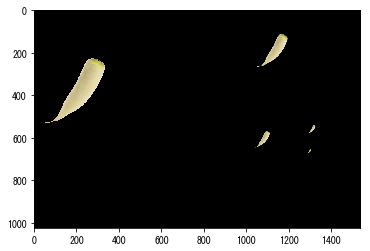

(2048, 1024, 3)

In [10]:
daikonname = "kabukabu.png" 
src = cv2.imread(daikonname,1)
mimg = mulresimg(src)
showMimg(mimg)
b2img.shape

無駄な空間が多い。  
マージンカットして多重解像度画像を作ってみる。

In [11]:
h = src.shape[0]
math.ceil(math.log(h,2))

10

410 327 -> 512 512


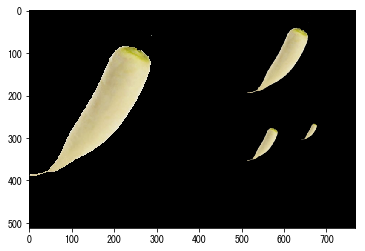

In [12]:
daikonname = "kabukabu.png" 
src = cv2.imread(daikonname,1)
mimg = mulresimg(src,pad=5)
showMimg(mimg);

(960, 720, 3)
(960, 720, 3)
(645, 627, 3)


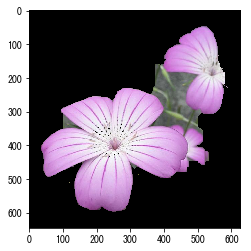

((645, 627, 3), (960, 720, 3))

In [13]:
filename = "pics/IMG_5357.jpg" 
src = cv2.imread(filename,1)
print(src.shape)
img = grubcut(src, offset=5)
print(img.shape)
img,_ = margincut(img, pad=5)
print(img.shape)
plt.imshow(img[:,:,::-1])
plt.show()
img.shape,src.shape

463 428 -> 512 512


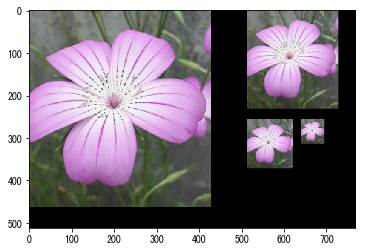

(2048, 1024, 3)

In [14]:
mimg = mulresimg(src,minsize=64,pad=5,offset=25)
showMimg(mimg)
b2img.shape

1144 506 -> 2048 512


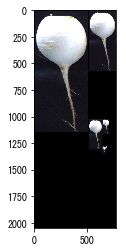

In [15]:
daikonname = "pics/daikonkabu.jpg" 
src = cv2.imread(daikonname,1)
mm = mulresimg(src,minsize=64,pad=3,offset=10)
showMimg(mm);

# Grubcut にかかる時間

In [16]:
daikonname = "pics/horyou1c1k.jpg" 
%time drc = cv2.imread(daikonname,1) # 読み込み時間

CPU times: user 468 ms, sys: 52.4 ms, total: 520 ms
Wall time: 588 ms


In [17]:
%time b2img = getbase2img(drc) # ２のべき乗サイズ変換にかかる時間

3000 4000 -> 4096 4096
CPU times: user 24.4 ms, sys: 30.9 ms, total: 55.3 ms
Wall time: 58.5 ms


In [18]:
%time mimg = mulresimg(b2img) # マージンカットしない場合の多重解像度画像生成時間

4096 4096 -> 4096 4096
CPU times: user 177 ms, sys: 77.9 ms, total: 255 ms
Wall time: 293 ms


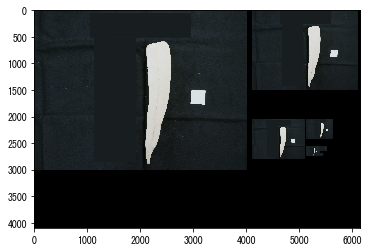

CPU times: user 2.26 s, sys: 295 ms, total: 2.55 s
Wall time: 2.8 s


In [19]:
%time mm=showMimg(mimg);  # 多重解像度画像の合成と表示にかかる時間


In [20]:
len(mimg) # 多重度

7

以下、解像度の低い方から、grubcut にかかる時間を計測してみる

CPU times: user 17 ms, sys: 2.44 ms, total: 19.4 ms
Wall time: 23.2 ms
CPU times: user 384 µs, sys: 129 µs, total: 513 µs
Wall time: 421 µs


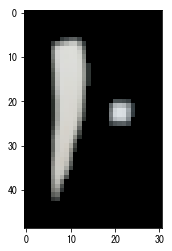

In [21]:
% time gimg = grubcut(mimg[6], offset=10)
% time gimg,_ = margincut(gimg,pad=10)
plt.imshow(gimg[:,:,::-1])
plt.show()

CPU times: user 111 ms, sys: 5.38 ms, total: 116 ms
Wall time: 123 ms
CPU times: user 432 µs, sys: 115 µs, total: 547 µs
Wall time: 522 µs


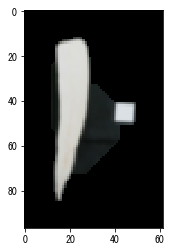

In [22]:
% time gimg = grubcut(mimg[5], offset=10)
% time gimg,_ = margincut(gimg,pad=10)
plt.imshow(gimg[:,:,::-1])
plt.show()

CPU times: user 522 ms, sys: 46.8 ms, total: 569 ms
Wall time: 576 ms
CPU times: user 615 µs, sys: 129 µs, total: 744 µs
Wall time: 807 µs


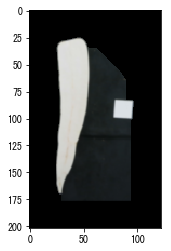

In [23]:
% time gimg = grubcut(mimg[4], offset=10)
% time gimg ,_= margincut(gimg,pad=10)
plt.imshow(gimg[:,:,::-1])
plt.show()

CPU times: user 2.95 s, sys: 85.7 ms, total: 3.03 s
Wall time: 2.83 s
CPU times: user 1.93 ms, sys: 408 µs, total: 2.33 ms
Wall time: 1.49 ms


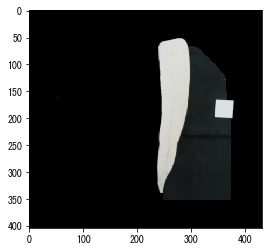

In [24]:
% time gimg = grubcut(mimg[3], offset=10)
% time gimg,_ = margincut(gimg,pad=10)
plt.imshow(gimg[:,:,::-1])
plt.show()

CPU times: user 20.9 s, sys: 350 ms, total: 21.2 s
Wall time: 20 s
CPU times: user 7.01 ms, sys: 704 µs, total: 7.71 ms
Wall time: 4.02 ms


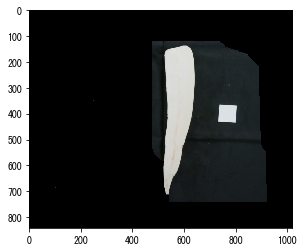

In [25]:
% time gimg = grubcut(mimg[2], offset=10)
% time gimg,_ = margincut(gimg,pad=10)
plt.imshow(gimg[:,:,::-1])
plt.show()

CPU times: user 1min 41s, sys: 1.72 s, total: 1min 43s
Wall time: 1min 39s
CPU times: user 24.6 ms, sys: 5.68 ms, total: 30.3 ms
Wall time: 18.2 ms


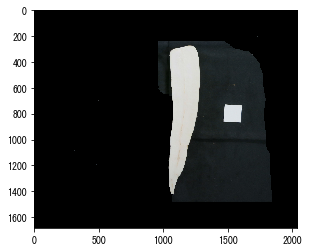

In [26]:
% time gimg = grubcut(mimg[1], offset=10)
% time gimg,_ = margincut(gimg,pad=10)
plt.imshow(gimg[:,:,::-1])
plt.show()

In [27]:
'''% time gimg = grubcut(mimg[0], offset=10)
% time gimg = margincut(gimg,pad=10)
plt.imshow(gimg[:,:,::-1])
plt.show()'''

'% time gimg = grubcut(mimg[0], offset=10)\n% time gimg = margincut(gimg,pad=10)\nplt.imshow(gimg[:,:,::-1])\nplt.show()'

これは動かさないほうがよい。メモリ不足でスワッピングが始まり３０分たっても終わらず、高負荷のため他の仕事ができなくなった。

2287 1374 -> 4096 2048
CPU times: user 604 ms, sys: 53.6 ms, total: 658 ms
Wall time: 580 ms


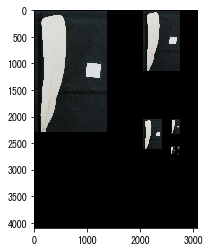

In [28]:
% time mm = mulresimg(drc,minsize=64,pad=3,offset=10)
mimg = showMimg(mm)

In [47]:
showBigImage(mimg)

In [31]:
cv2.destroyAllWindows()        
cv2.waitKey(1)

-1